## NYT API: Example with Electric Vehicles for GM and Tesla 

In [3]:
from __future__ import division
import pandas
from matplotlib import pyplot as plt 
import seaborn as sns
import requests
import urllib.parse
import json
import math
import time
import csv
# from textblob import TextBlob
# replace textblob with NLTK (included in Anaconda)
# use NLTK’s build-in Vader Sentiment Analyzer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Tim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## This is background info on the NYTimes API for the audience

>#### (from NYTimes API FAQ, https://developer.nytimes.com/faq) the Article Search API is rate limited to 1,000 calls per day, and 1 call per second. If you need a higher rate limit, please contact us at code@nytimes.com.

>#### we'll be using the NYTimes article_search API; this searches NYTimes artiles from Sept 18, 1851 to today, retrieving headlines, abstracts, lead paragraphs, links to associated multimedia and other articl..

### The article_search API has the following parameters (not all need to be used):

> ##### _q_ - Search query term. Search is performed on the article body, headline and byline

> ##### _fq_ - "Filtered search query using standard Lucene syntax. The filter query can be specified with or without a limiting field: label. See Filtering Your Search for more information about filtering."

> ##### _begin_date_ - "Format: YYYYMMDD Restricts responses to results with publication dates of the date specified or later."

> ##### _end_date_ - "Format: YYYYMMDD Restricts responses to results with publication dates of the date specified or earlier."

> ##### _sort_ - "By default, search results are sorted by their relevance to the query term (q). Use the sort parameter to sort by pub_date." Allowed values are: newest, oldest


##### manually check this against the NYTimes search webpage: https://www.nytimes.com/search/%22electric%20vehicle%22%20%22charging%22/best/20170101/20180101
##### or use their console: http://developer.nytimes.com/article_search_v2.json#/Console/GET/articlesearch.json

#### Note: NYTimes API does not seem to support wildcard characters or substring queries

In [4]:
def grab_data(companyName, query, start_date, end_date): #"20100101"

    # set key
    key = "23024af0531e446c99d96a8dcfb5cf09"

    # set base url
    base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

    # set search parameters
    search_params = {"fq": query,
                     "api-key": key,
                     "begin_date": start_date ,  # date must be in YYYYMMDD format
                     "end_date": end_date,
                     "sort":"newest"}

    print (search_params)
    
    # make request
    r = requests.get(base_url, params=search_params)

    # wait 3 seconds for the GET request
    time.sleep(3)

    # convert to a dictionary
    data = json.loads(r.text)

    # get number of hits
    hits = data['response']['meta']['hits']
    print("number of hits: ", str(hits))

    # get number of pages
    pages = int(math.ceil(hits / 10))
    print("number of pages: ", str(pages))
    
    data_all = list()
    
    # now we're ready to loop through the pages
    for i in range(pages):
        print("collecting page", str(i))

        # set the page parameter
        search_params['page'] = i

        # make request
        r = requests.get(base_url, params=search_params)

        # get text and convert to a dictionary
        data = json.loads(r.text)
        
        # append dictionary to master list
        data_all.append(data)
        time.sleep(3)  # pause between calls
    filename = '../data/nyt_%s_ev.txt' % companyName
    with open(filename, 'w') as outfile:
        json.dump(data_all, outfile)
    return data_all

In [5]:
def gen_df(data):

    # make an empty dataframe where we'll hold all of our docs for every page
    all_docs = pandas.DataFrame()
    for e in data:
        # get just the docs
        # because some responses are just messages, we need to only gather those with data
        if "response" in e.keys():
            docs = e['response']['docs']
            df_temp = pandas.DataFrame(docs)
            # add those docs to the dataframe
            all_docs = pandas.concat([all_docs, df_temp], ignore_index=True)
    return(all_docs)

In [6]:
def polarity(text):
    sentiment_engine_nltk_vader = SentimentIntensityAnalyzer()
    # vader is one of NLTK's sentiment approaches (we could just simply and leave out that detail)
    score = sentiment_engine_nltk_vader.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

In [7]:
def clean_data(df):
    df['year'] = df['pub_date'].str[:4]
    df['polarity'] = df['snippet'].apply(polarity)
    grouped = df[['year','_id']].groupby('year').count()
    grouped_text = df[['year', 'polarity']].groupby('year').mean()
    grouped_all = grouped.join(grouped_text)
    grouped_all.rename(columns={'_id': 'count'}, inplace=True)
    grouped_all = grouped_all.fillna(0)
    return grouped_all

## We start to run the main code here, for the NYTimes, we can set whether we want to search the body, headline, or byline; because there are no partial word searches, we need to take advantage of boolean operators (AND, OR) to combine variations on strings

In [21]:
gm_query='(body:"GM") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")'

In [22]:
tesla_query='(body:"Tesla") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")'

In [62]:
data_gm_ev = grab_data("gm", gm_query, 20050101, 20160101)

{'fq': '(body:"GM") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")', 'api-key': '23024af0531e446c99d96a8dcfb5cf09', 'begin_date': 20050101, 'end_date': 20160101, 'sort': 'newest'}
number of hits:  38
number of pages:  4
collecting page 0
collecting page 1
collecting page 2
collecting page 3


In [63]:
data_tesla_ev = grab_data("tesla", tesla_query, 20050101, 20160101)

{'fq': '(body:"Tesla") AND (body:"electric car" OR body:"electric cars" OR body:"electric vehicle" OR body:"electric vehicles")', 'api-key': '23024af0531e446c99d96a8dcfb5cf09', 'begin_date': 20050101, 'end_date': 20160101, 'sort': 'newest'}
number of hits:  739
number of pages:  74
collecting page 0
collecting page 1
collecting page 2
collecting page 3
collecting page 4
collecting page 5
collecting page 6
collecting page 7
collecting page 8
collecting page 9
collecting page 10
collecting page 11
collecting page 12
collecting page 13
collecting page 14
collecting page 15
collecting page 16
collecting page 17
collecting page 18
collecting page 19
collecting page 20
collecting page 21
collecting page 22
collecting page 23
collecting page 24
collecting page 25
collecting page 26
collecting page 27
collecting page 28
collecting page 29
collecting page 30
collecting page 31
collecting page 32
collecting page 33
collecting page 34
collecting page 35
collecting page 36
collecting page 37
colle

### we have generated two files on disk with the output of the NYTimes search, let's load them here

In [65]:
with open("../data/nyt_gm_ev.txt", 'r') as file:
    data_gm_ev = json.load(file)

In [66]:
with open("../data/nyt_tesla_ev.txt", 'r') as file:
    data_tesla_ev = json.load(file)

### turn these data into Dataframes

In [67]:
df_gm = gen_df(data_gm_ev)

In [68]:
df_tesla = gen_df(data_tesla_ev)

### Clean the data

In [69]:
grouped_gm = clean_data(df_gm)

In [70]:
grouped_tesla = clean_data(df_tesla)

### Inspect the grouped data

In [71]:
grouped_gm.head()

,count,polarity
year,,
2005,1,1.000000
2006,1,0.000000
2007,4,0.500000
2008,5,0.400000
2009,9,0.222222


In [72]:
grouped_tesla.head()

,count,polarity
year,,
2006,6,0.333333
2007,28,0.535714
2008,57,0.526316
2009,78,0.512821
2010,157,0.503185


### Plot the count column in our dataframe

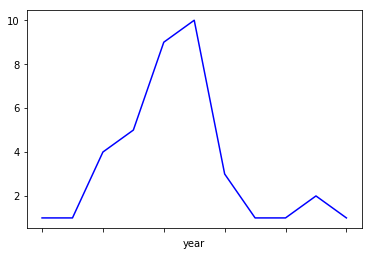

In [96]:
grouped_gm['count'].plot(kind='line', color='b')

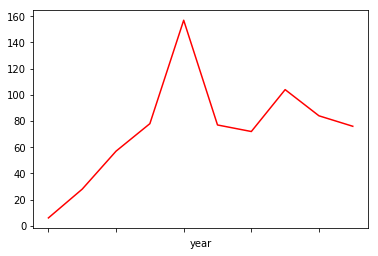

In [97]:
grouped_tesla['count'].plot(kind='line', color='r')

### _to do: bring the xticks back in for year_ 

### Show both plots on the same graph

In [75]:
combined_df = pandas.concat([grouped_gm, grouped_tesla], axis=1)

In [76]:
# need to rename our columns and index (note: this could be avoided through better use of the concat function above)
combined_df.columns=["GM_count", "GM_polarity", "Tesla_count", "Tesla_polarity"]
combined_df.index_name = "year"

In [77]:
combined_df = combined_df.fillna(0)

In [78]:
combined_df.head()

,GM_count,GM_polarity,Tesla_count,Tesla_polarity
2005,1,1.000000,0.0,0.000000
2006,1,0.000000,6.0,0.333333
2007,4,0.500000,28.0,0.535714
2008,5,0.400000,57.0,0.526316
2009,9,0.222222,78.0,0.512821


### Plot the combined dataframe

In [79]:
combined_df[["GM_count", "Tesla_count"]]

,GM_count,Tesla_count
2005,1,0.0
2006,1,6.0
2007,4,28.0
2008,5,57.0
2009,9,78.0
2010,10,157.0
2011,3,77.0
2012,1,72.0
2013,1,104.0
2014,2,84.0


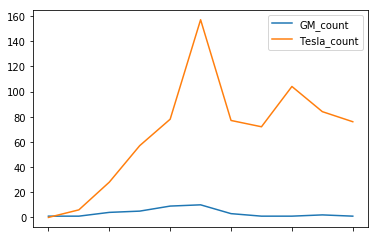

In [80]:
combined_df[["GM_count", "Tesla_count"]].plot()

## 2010 was a big year for Tesla, and GM [Hovig to fill in what happened in 2010 from the case]

In [81]:
combined_df[["GM_polarity","Tesla_polarity"]]

,GM_polarity,Tesla_polarity
2005,1.000000,0.000000
2006,0.000000,0.333333
2007,0.500000,0.535714
2008,0.400000,0.526316
2009,0.222222,0.512821
2010,0.600000,0.503185
2011,0.333333,0.376623
2012,1.000000,0.430556
2013,1.000000,0.403846
2014,0.000000,0.488095


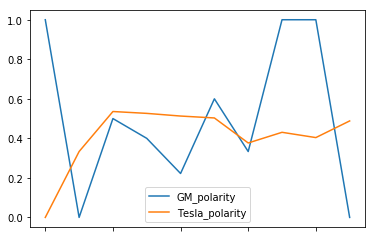

In [56]:
combined_df[["GM_polarity","Tesla_polarity"]].plot()

### 2005 might be misleading because there is only a single article for GM (it is positive); trying again with 2006-2015

In [82]:
combined_df[["GM_polarity","Tesla_polarity"]].iloc[1:]

,GM_polarity,Tesla_polarity
2006,0.000000,0.333333
2007,0.500000,0.535714
2008,0.400000,0.526316
2009,0.222222,0.512821
2010,0.600000,0.503185
2011,0.333333,0.376623
2012,1.000000,0.430556
2013,1.000000,0.403846
2014,0.000000,0.488095
2015,1.000000,0.447368


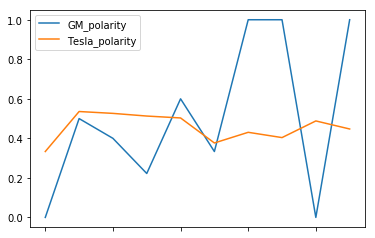

In [83]:
combined_df[["GM_polarity","Tesla_polarity"]].iloc[1:].plot()